In [1]:
from __future__ import print_function, division

from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import regex as re

cudnn.benchmark = True
plt.ion()

In [2]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
device

device(type='cpu')

In [3]:
## Define directory for data
IMAGE_DIRECTORIES = {'train': r"E:\Blender\BlenderPythonTest\output_light\train",
                     'val': r"E:\Blender\BlenderPythonTest\output_light\val"}

In [4]:
## Data augmentations to... inflate the dataset? Logic must be somewhere to do that.
## We are NOT stretching, cropping, resizing, etc, since size information is
## pertinent to learning what the size of the object in the image is, the fullness of the glass, etc.

data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomRotation(180),
        transforms.Resize(224),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor()
    ]),
}

In [5]:
## Define the dataset, and regex default for pulling the float labels out of the image name.

class ImageFilenameDataset(Dataset):
    ## Where the label is in the filename
    
    def __init__(self, root_dir, transform, _device, reg_exp_string="\d*\.\d*"):
        self.root_dir = root_dir
        self.transform = transform
        self.rel_filepaths = []
        self.reg_exp_string = reg_exp_string
        
        for path in os.listdir(self.root_dir):
            self.rel_filepaths.append(path)
        
    def __len__(self):
        return len(self.rel_filepaths)
    
    def __getitem__(self, idx):
        img_rel_path = self.rel_filepaths[idx]
        img_abs_path = os.path.join(self.root_dir, img_rel_path)
        image = Image.open(img_abs_path)
        image_tensor = self.transform(image)
        value = torch.tensor([float(re.search(self.reg_exp_string, img_rel_path).group())], dtype=torch.float32)
        return (image_tensor, value)

In [6]:
# test_train_set = ImageFilenameDataset(IMAGE_DIRECTORIES['train'], data_transforms['train'], device)
# print(test_train_set.__len__())

# test_train_dloader = torch.utils.data.DataLoader(test_train_set, batch_size=8, shuffle=True, num_workers=0)
# print(len(test_train_dloader))
# im, la = next(iter(test_train_dloader))
# print(im[0])
# print(la[0])

In [7]:
image_datasets = {x : ImageFilenameDataset(IMAGE_DIRECTORIES[x], 
                                           data_transforms[x],
                                          device)
                 for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=0)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

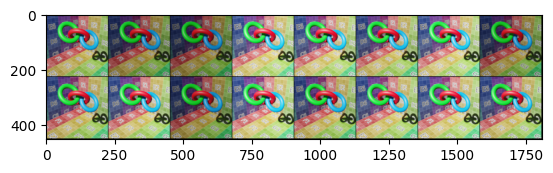

In [8]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get batch of training data
images, labels = next(iter(dataloaders['train']))#.values() # WHY THE FUCK WOULD I HAVE TO CALL .VALUES() ON THE DATALOADER!?

# Make grid of the batch to display
out = torchvision.utils.make_grid(images)

imshow(out)#, title=[str(x.item()) for x in labels])

In [9]:
def train_model(model, loss_func, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_loss = 10000.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    
                    outputs = model(inputs)
                    loss = loss_func(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # stats
                running_loss += loss.item() * inputs.size(0)
                
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                torch.save(model.state_dict(), "finetune_best_model")
            
            print(f'{phase} Loss: {epoch_loss:.4f}')
        
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    
    
    print(f'Best loss: {best_loss}, loading best weights now.')
    model.load_state_dict(torch.load("finetune_best_model"))
    
    return model

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            #_, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                
                pred = outputs[j].item()
                label = labels[j].item()
                ax.set_title(f'predicted: {np.round(pred,3)}  labelled: {np.round(label,3)}  error: {np.round(error(pred, label),3)}%')  # labelled: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
            
            model.train(mode=was_training)

def error(true, pred):
    return abs((true - pred) / true) * 100

In [11]:
# Finetune deep method
model_ft = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 1)

model_ft = model_ft.to(device)

loss_func = nn.MSELoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [12]:
model_ft = train_model(model_ft, loss_func, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 18.4398
val Loss: 71.1234
Epoch 1/29
----------
train Loss: 7.3607
val Loss: 57.3533
Epoch 2/29
----------
train Loss: 10.2888
val Loss: 17.2435
Epoch 3/29
----------
train Loss: 7.7925
val Loss: 4.3670
Epoch 4/29
----------
train Loss: 10.2716
val Loss: 0.3386
Epoch 5/29
----------
train Loss: 4.6616
val Loss: 3.9224
Epoch 6/29
----------
train Loss: 2.7574
val Loss: 0.0780
Epoch 7/29
----------
train Loss: 2.9555
val Loss: 0.2234
Epoch 8/29
----------
train Loss: 1.9784
val Loss: 0.0672
Epoch 9/29
----------
train Loss: 1.8321
val Loss: 0.0251
Epoch 10/29
----------
train Loss: 1.9998
val Loss: 0.4780
Epoch 11/29
----------
train Loss: 1.4065
val Loss: 0.0426
Epoch 12/29
----------
train Loss: 1.9931
val Loss: 0.5898
Epoch 13/29
----------
train Loss: 1.5606
val Loss: 0.3556
Epoch 14/29
----------
train Loss: 1.9747
val Loss: 0.0321
Epoch 15/29
----------
train Loss: 1.2556
val Loss: 0.0800
Epoch 16/29
----------
train Loss: 1.5847
val Loss: 0.0104
E

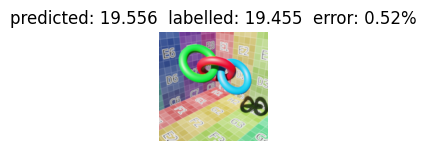

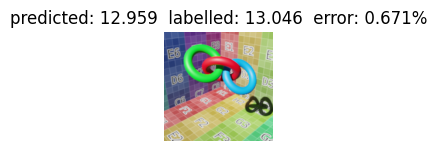

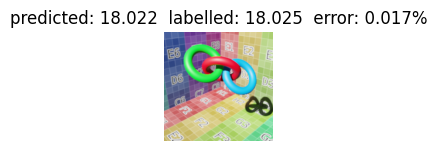

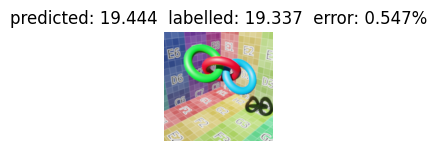

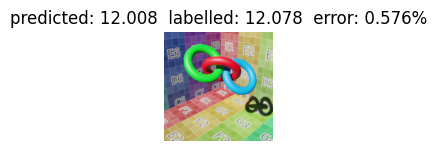

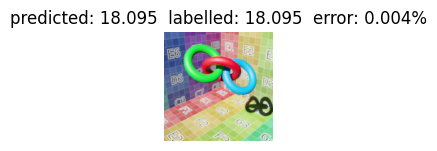

In [13]:
visualize_model(model_ft)

In [ ]:
USE_MODEL_CONV = False

if USE_MODEL_CONV:
    model_conv = torchvision.models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

    for param in model_conv.parameters():
        param.requires_grad = False

    num_ftrs = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_ftrs, 1)

    model_conv = model_conv.to(device)

    criterion = nn.MSELoss()

    # only optimize paramters of final layer OOOHHHHHHHHH
    optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

    # same decay 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size = 7, gamma=0.1)

In [ ]:
if USE_MODEL_CONV:
    model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler)#, num_epochs=45)

In [ ]:
if USE_MODEL_CONV:
    visualize_model(model_conv)